In [31]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [32]:
%matplotlib inline

In [33]:
import feature_extraction
import scoring

from text_preprocessor import TextPreprocessor
from main import get_candidates, get_neighbor_candidates, get_citation_candidates

In [34]:
citations = TextPreprocessor(use_cfg='config/test.cfg')

In [35]:
def show_wordcloud(data):
    plt.figure(figsize = (8,6))
    wordcloud = WordCloud().fit_words(data)
    plt.imshow(wordcloud, aspect='auto')
    plt.axis("off")

In [36]:
def generate_ranking(method, pmid, bigger_is_better=True):
    candidates = get_candidates(citations, pmid)
    if len(candidates) == 0: print(pmid)
    scored = [(method(citations, pmid, c), c) for c in candidates]
    return [candidate for _, candidate in sorted(scored, reverse=bigger_is_better)]

In [23]:
# Modified for rank ensembling two models
# def generate_ranking(method, pmid, bigger_is_better=True):
#     cite_candidates = get_citation_candidates(citations, pmid)
#     neigh_candidates = get_neighbor_candidates(citations, pmid)
#     if len(cite_candidates) == 0: print(pmid)
#     if len(neigh_candidates) == 0: print(pmid)

#     scored_cite = [(method(citations, pmid, c), c) for c in cite_candidates]
#     scored_neigh = [(method(citations, pmid, c), c) for c in neigh_candidates]
#     scores = {k:v  for v,k in scored_cite} # Begin as citation scores
#     neigh_mesh_scores = {k:v for v,k in scored_neigh} # Sum neighbor scores
#     for k,v in neigh_mesh_scores.items():
#         if k in scores:
#             scores[k] += v
#         else:
#             scores[k] = v
#     scored = [(v, k) for k, v in scores.items()]
#     return [candidate for _, candidate in sorted(scored, reverse=bigger_is_better)]

In [37]:
def get_predictions(method, bigger_is_better=True):
    return [generate_ranking(method, pmid, bigger_is_better) for pmid in citations.articles]

In [38]:
def evaluate_for_k(actual, predicted, k=25):
    trimmed_rankings = []
    for ranking in predicted:
        if k < len(ranking): trimmed_rankings.append(ranking[:k])
        else: trimmed_rankings.append(ranking)
    return scoring.get_scores(trimmed_rankings, actual)

In [39]:
def get_roc_vals(method, bigger_is_better=True):
    predicted = get_predictions(method, bigger_is_better)
    actual = [citations[pmid]['mesh'] for pmid in citations.articles]
    return [(k, evaluate_for_k(actual, predicted, k=k)) for k in range(1,30)]

In [40]:
def get_plot_points(label, method, color, bigger_is_better=True):
    values = get_roc_vals(method, bigger_is_better)
    precision = [precision for k, (precision, recall, fscore, map_) in values]
    recall = [recall for k, (precision, recall, fscore, map_) in values]
    fscore = [fscore for k, (precision, recall, fscore, map_) in values]
    k = [k for k, (precision, recall, fscore, map_) in values]
    map_ = [map_ for k, (precision, recall, fscore, map_) in values]
    
    return {
        'pr' : {'x': precision, 'y': recall, 'label': label, 'c':color},
        'kf' : {'x': k, 'y': fscore, 'label': label, 'c':color},
        'km' : {'x': k, 'y': map_, 'label': label, 'c':color}
    }  

In [41]:
def plot_figures(features, title='Ranking based on individual features'):
    data = []
    for label, (method, color) in features.items():
        points = get_plot_points(label, method, color)
        data.append(points)
    
    plt.figure(1, figsize=(40,12))
    label = plt.suptitle(title)
    label.set_fontsize(20)
    
    pr_plot = plt.subplot(1, 3, 1)
    kf_plot = plt.subplot(1, 3, 2)
    km_plot = plt.subplot(1, 3, 3)

    
    for points in data:
        pr_plot.scatter(**points['pr'])
        kf_plot.scatter(**points['kf'])
        km_plot.scatter(**points['km'])
        
    plt.subplot(1, 3, 1)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Recall vs Precision')
    plt.legend(loc='upper right')
    
    plt.subplot(1, 3, 2)
    plt.xlabel('Number of items in ranking')
    plt.ylabel('F-Score')
    plt.title('F-Score vs k')
    plt.legend(loc='lower right')
    
    plt.subplot(1, 3, 3)
    plt.xlabel('Number of items in ranking')
    plt.ylabel('MAP')
    plt.title('Mean Average Precision (MAP) vs k')
    plt.legend(loc='lower right')

In [42]:
import random
from collections import OrderedDict
features = OrderedDict([
    ('Bigram Overlap', (feature_extraction.bigram_overlap, 'pink')),
    ('Unigram Overlap', (feature_extraction.unigram_overlap, 'purple')),
    ('Neighboring Count', (feature_extraction.neighboring_count, 'r')),
    ('Neighboring Similarity', (feature_extraction.neighboring_similarities, 'g')), 
    ('Citation Count', (feature_extraction.citation_count, 'y')),
    ('Citation Similarity', (feature_extraction.citation_similarities, 'orange')),
    ('Random', (lambda x,y,z:random.randint(0,200), 'b')),
    ('Composite', (lambda x,y,z:feature_extraction.neighboring_count(x,y,z)+feature_extraction.citation_count(x,y,z), 'limegreen'))
])

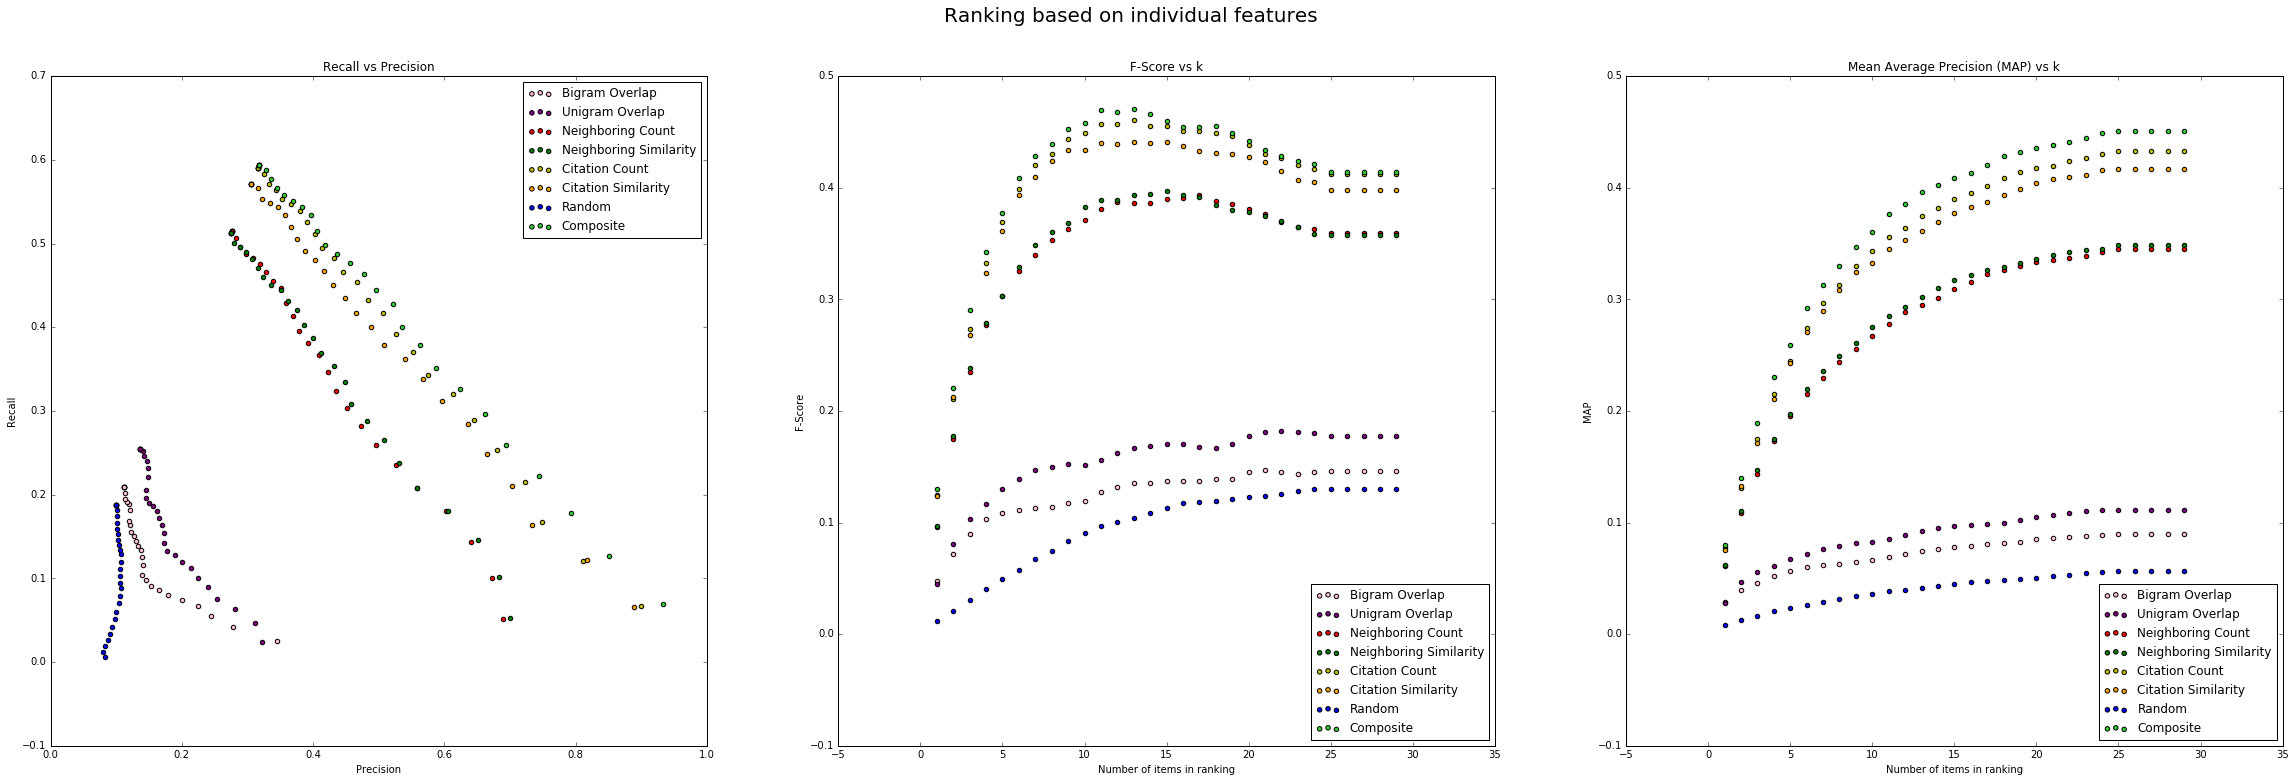

In [43]:
plot_figures(features)

In [44]:
from functools import partial
from feature_extraction import features as all_features
from listnet import ListNet
from sklearn.preprocessing import MinMaxScaler

class LNet():
    def __init__(self):
        self.current_file = None

    def switch(self, num_iters, learning_rate):
        with open('models/model_iter{0}_gamma{1}'.format(num_iters, learning_rate)) as params_file:
            self.weights = np.asarray([float(weight) for weight in params_file.readlines()])

    def get_score(self, citations, pmid, mesh_term):
        feats = np.asarray([func(citations, pmid, mesh_term) for func in all_features])
        return self.weights @ feats

#     @staticmethod
#     def scale_features(features):
#         # Scale the features
#         feature_matrix = np.vstack(features)
#         min_max_scaler = MinMaxScaler()
#         return min_max_scaler.fit_transform(feature_matrix)


                


def listnet_score(lnet, citations, pmid, mesh_term):
    return lnet.get_score(citations, pmid, mesh_term)

model = LNet()

In [45]:
def run_model(citations, pmid, mesh_term, iterations, gamma):
    model.switch(iterations, gamma)
    return listnet_score(model, citations, pmid, mesh_term)

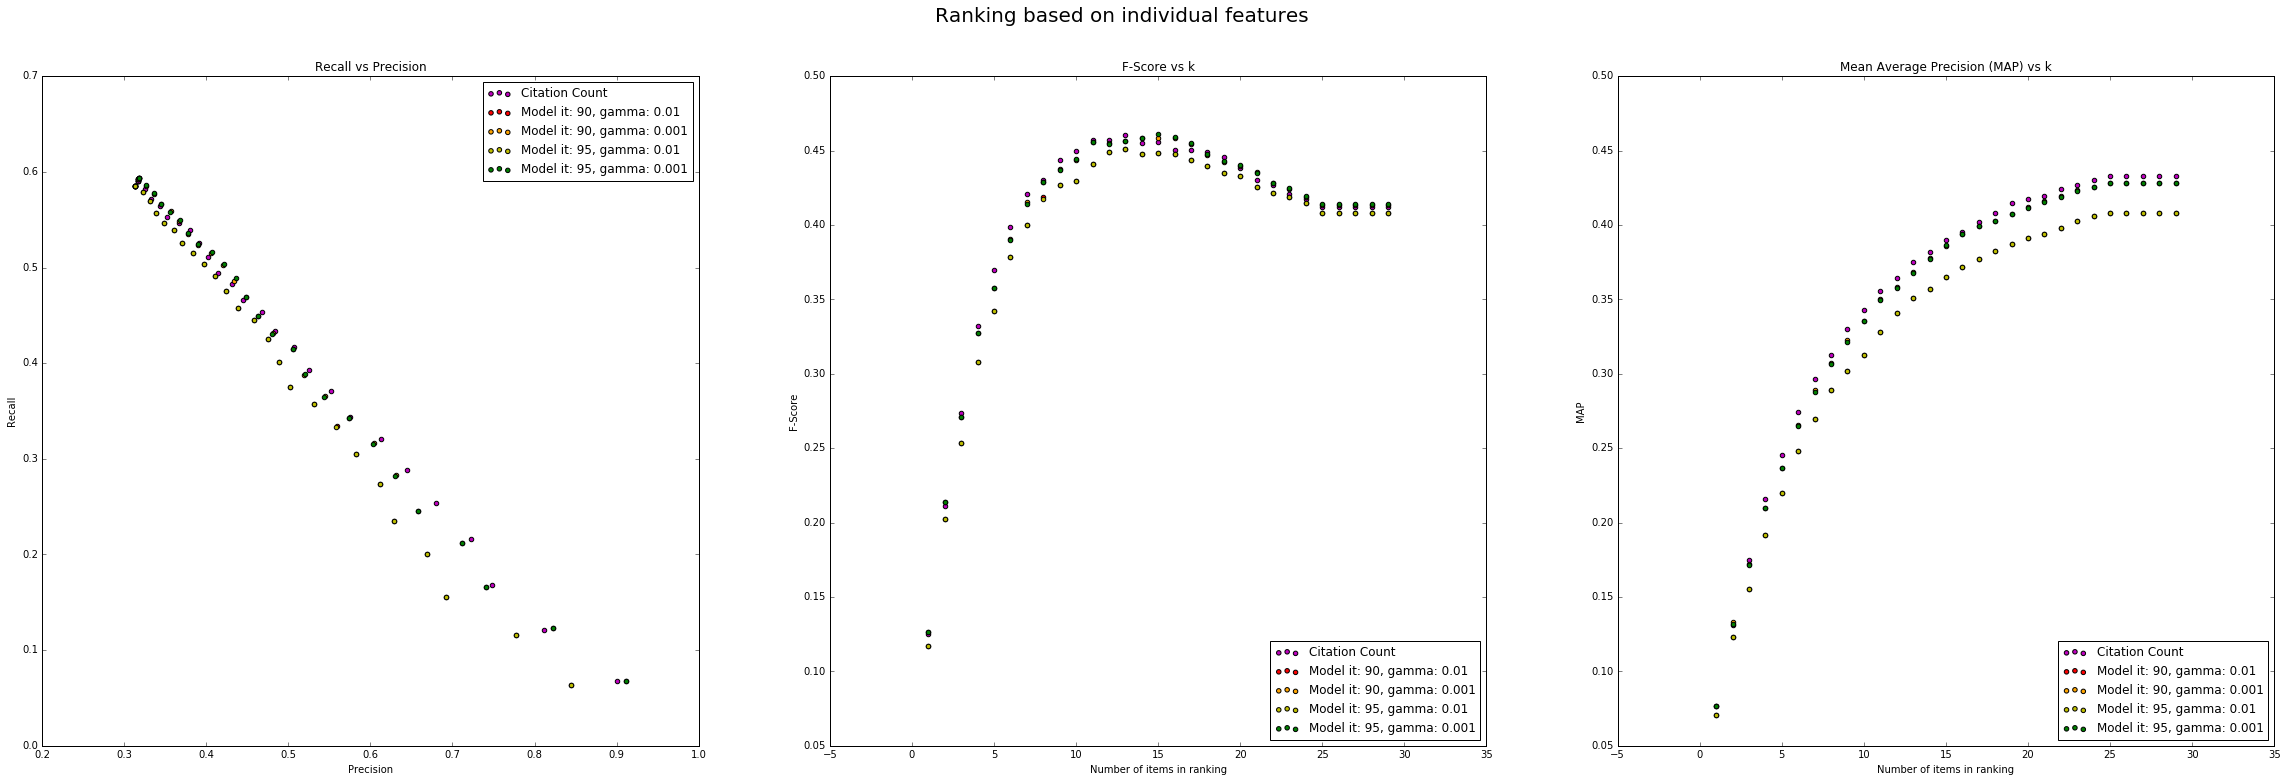

In [48]:
import random
from collections import OrderedDict
from itertools import cycle

from itertools import product
iterations = list(range(90,100,5))
# iterations = list(100, 105)
gamma = [0.01, 0.001]
color_cycle = cycle(['r', 'orange', 'y', 'g', 'b', 'indigo', 'violet', 'teal', 'powderblue'])

graphs = [('Citation Count', (feature_extraction.citation_count, 'm'))]
for it, gm in product(iterations, gamma):
    graphs.append(
        (
            'Model it: {}, gamma: {}'.format(it, gm),
            (partial(run_model, iterations=it, gamma=gm), next(color_cycle))
        )
    )

huytay = OrderedDict(graphs)
plot_figures(huytay)

In [50]:
points = get_plot_points('Label', partial(run_model, iterations=90, gamma=0.001), 'r')


In [51]:
for k, mean_avg_precision in zip(points['km']['x'], points['km']['y']):
    print('k={} MAP={}'.format(k, mean_avg_precision))

k=1 MAP=0.07672192948981728
k=2 MAP=0.13290696328923016
k=3 MAP=0.17202329160920488
k=4 MAP=0.21014312653943282
k=5 MAP=0.23675124772108355
k=6 MAP=0.26548738464757987
k=7 MAP=0.2888675664639871
k=8 MAP=0.30714508740485286
k=9 MAP=0.32252398865043613
k=10 MAP=0.3356400631472296
k=11 MAP=0.34994883362989065
k=12 MAP=0.3586584330729568
k=13 MAP=0.3682585689155511
k=14 MAP=0.37757974640439035
k=15 MAP=0.3860806116732295
k=16 MAP=0.3938795303131408
k=17 MAP=0.3993284633485792
k=18 MAP=0.4029649822787141
k=19 MAP=0.4075147333532329
k=20 MAP=0.4119592439987239
k=21 MAP=0.41643332111986
k=22 MAP=0.4192329289194675
k=23 MAP=0.42331993124176387
k=24 MAP=0.42582731767537735
k=25 MAP=0.4283370463635373
k=26 MAP=0.4283370463635373
k=27 MAP=0.4283370463635373
k=28 MAP=0.4283370463635373
k=29 MAP=0.4283370463635373


In [52]:
for k, prec, rec in zip(range(1, 31), points['pr']['x'], points['km']['y']):
    print('k={}, precision={}, recall={}'.format(k, prec, rec))

k=1, precision=0.9111111111111111, recall=0.07672192948981728
k=2, precision=0.8222222222222222, recall=0.13290696328923016
k=3, precision=0.7407407407407407, recall=0.17202329160920488
k=4, precision=0.7111111111111111, recall=0.21014312653943282
k=5, precision=0.6577777777777778, recall=0.23675124772108355
k=6, precision=0.6314814814814815, recall=0.26548738464757987
k=7, precision=0.6047619047619047, recall=0.2888675664639871
k=8, precision=0.5736111111111111, recall=0.30714508740485286
k=9, precision=0.5444444444444444, recall=0.32252398865043613
k=10, precision=0.5188888888888888, recall=0.3356400631472296
k=11, precision=0.5050505050505051, recall=0.34994883362989065
k=12, precision=0.48148148148148145, recall=0.3586584330729568
k=13, precision=0.46324786324786327, recall=0.3682585689155511
k=14, precision=0.44841269841269843, recall=0.37757974640439035
k=15, precision=0.43407407407407406, recall=0.3860806116732295
k=16, precision=0.42083333333333334, recall=0.3938795303131408
k=

In [53]:
for k, fscore in zip(points['kf']['x'], points['kf']['y']):
    print('k={}, f-score={}'.format(k, fscore))

k=1, f-score=0.12664092664092663
k=2, f-score=0.21371841155234655
k=3, f-score=0.2711864406779661
k=4, f-score=0.3271565495207667
k=5, f-score=0.3577039274924471
k=6, f-score=0.39083094555873926
k=7, f-score=0.41525885558583103
k=8, f-score=0.4290909090909091
k=9, f-score=0.4377171215880893
k=10, f-score=0.4437054631828978
k=11, f-score=0.45558086560364475
k=12, f-score=0.4551422319474836
k=13, f-score=0.45642105263157895
k=14, f-score=0.4584178498985801
k=15, f-score=0.4587084148727984
k=16, f-score=0.4582230623818525
k=17, f-score=0.4541133455210238
k=18, f-score=0.4467256637168142
k=19, f-score=0.4425385934819897
k=20, f-score=0.4399334442595674
k=21, f-score=0.4355411954765751
k=22, f-score=0.4282574568288854
k=23, f-score=0.4244274809160305
k=24, f-score=0.41901931649331353
k=25, f-score=0.41331403762662805
k=26, f-score=0.41331403762662805
k=27, f-score=0.41331403762662805
k=28, f-score=0.41331403762662805
k=29, f-score=0.41331403762662805
